In [5]:
import torch
import utils
import torch.nn as nn
import torch.optim as optim
from model import Model
from torchvision.datasets import Cityscapes
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import wandb
import numpy as np

In [6]:
# Transform image scale, Tensor and normalize
scale = 4
     
transform = transforms.Compose([transforms.Resize((1024//scale, 2048//scale)), transforms.ToTensor(), transforms.Normalize((0.2869, 0.3251, 0.2839), (0.1870, 0.1902, 0.1872))])
target_transforms = transforms.Compose([transforms.Resize((1024//scale, 2048//scale),transforms.InterpolationMode.NEAREST), transforms.ToTensor()])

# Uncomment which data to use for the training
dataset = Cityscapes(root='./data', split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transforms)
#dataset = Cityscapes(root='./augmented_data', split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transforms)

# Split data in train and test data
train_indices = range(0,int(0.2 * len(dataset)))
val_indices = range(int(0.8 * len(dataset)),int(len(dataset)))
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, num_workers=12, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, num_workers=12, shuffle=True)

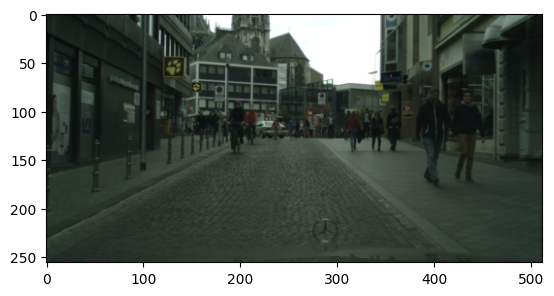

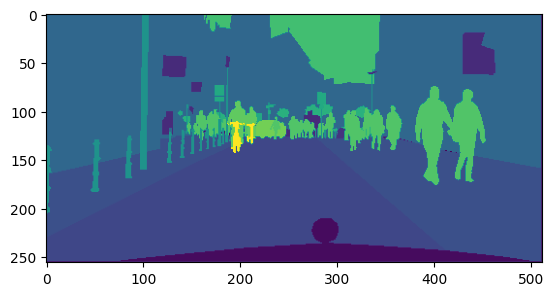

In [7]:
def denormalize(tensor, means, stds):
    denormalized = tensor.clone()
    for t, m, s in zip(denormalized, means, stds):
        t.mul_(s).add_(m)  # Denormaliseren
    return denormalized

means = (0.2869, 0.3251, 0.2839)
stds = (0.1870, 0.1902, 0.1872)
img, label = dataset[18]
img_denormalized = denormalize(img, means, stds)
img_denormalized = np.transpose(img_denormalized.numpy(), (1, 2, 0))


plt.imshow(img_denormalized)
plt.show()

img,label = dataset[18]
plt.imshow(label[0,:,:])
plt.show()

In [8]:
# define model
model = Model()

# define optimizer and loss function
learning_rate = 0.1
num_epochs = 15
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_classes = 19

# start a new wandb run to track this script
wandb.init(
    project="segmentation_project",
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "Cityscapes",
    "epochs": num_epochs,
    }
)

def dice_coefficient(y_true, y_pred, num_classes):
    """
    Function to calculate the Dice Coefficient for each class in a multi-class segmentation task.

    Parameters:
    y_true: numpy.array, true segmentation mask, where each pixel has an integer value representing the class
    y_pred: numpy.array, predicted segmentation mask, with the same dimensions and class representation as y_true
    num_classes: int, number of classes in the segmentation task

    Returns:
    dice_scores: list, Dice Coefficients for each class
    mean_dice_score: float, mean Dice Coefficient over all classes
    """
    
    dice_scores = []
    
    for class_id in range(num_classes):
        # Calculate intersection and union for the current class
        true_class = y_true == class_id
        pred_class = y_pred == class_id
        intersection = np.logical_and(true_class, pred_class)
        union = np.logical_or(true_class, pred_class)
        
        # Calculate Dice score for the current class
        if union.sum() == 0:  # to handle division by zero if there's no ground truth and no prediction for a class
            dice_score = 1.0 if intersection.sum() == 0 else 0.0
        else:
            dice_score = (2. * intersection.sum()) / (true_class.sum() + pred_class.sum())
        
        dice_scores.append(dice_score)
    
    # Calculate mean Dice score across all classes
    mean_dice_score = np.mean(dice_scores)
    
    return dice_scores, mean_dice_score

In [5]:
# training/validation loop
for epoch in range(num_epochs):
    train_loss = 0.0
    dice_scores_epoch = []
    val_loss = 0.0
    val_dice_scores_epoch = []
    
    model.train()
    for inputs, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        masks = (masks*255).squeeze(1).long()
        masks_final = utils.map_id_to_train_id(masks)
        loss = criterion(outputs, masks_final)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Convert model output to class predictions
        _, predicted_masks = torch.max(outputs, 1)
        dice_scores_batch, _ = dice_coefficient(masks_final.cpu().numpy(), predicted_masks.cpu().numpy(), num_classes)
        dice_scores_epoch.extend(dice_scores_batch)
    epoch_loss_train = train_loss / len(train_loader)
    mean_dice_score_epoch = np.mean(dice_scores_epoch)

    model.eval()
    with torch.inference_mode():
        for inputs, masks in val_loader:
            val_outputs = model(inputs)
            masks = (masks*255).squeeze(1).long()
            masks_final = utils.map_id_to_train_id(masks)
            val_loss_batch = criterion(val_outputs, masks_final)
            
            val_loss += val_loss_batch.item()

            _, val_predicted_masks = torch.max(val_outputs, 1)
            val_dice_scores_batch, _ = dice_coefficient(masks_final.cpu().numpy(), val_predicted_masks.cpu().numpy(), num_classes)
            val_dice_scores_epoch.extend(val_dice_scores_batch)
        


    # Calculate mean loss and mean dice score for the epoch
    epoch_loss_val = val_loss / len(val_loader)
    val_mean_dice_score_epoch = np.mean(val_dice_scores_epoch)  

    # Logging the metrics for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss train: {epoch_loss_train:.4f}, Loss val: {epoch_loss_val:.4f}, Mean Dice Score train: {mean_dice_score_epoch:.4f}, Mean Dice Score val: {val_mean_dice_score_epoch:.4f}')
    wandb.log({"loss_train": epoch_loss_train,"loss_val": epoch_loss_val,"Mean Dice Score train":mean_dice_score_epoch,"Mean Dice Score val":val_mean_dice_score_epoch})

wandb.finish()
# save model
torch.save(model.state_dict(),'./models/second_model.pth')

Epoch [1/15], Loss train: 1.2825, Loss val: 1.5438, Mean Dice Score train: 0.3004, Mean Dice Score val: 0.3023
Epoch [2/15], Loss train: 0.9772, Loss val: 1.1175, Mean Dice Score train: 0.3512, Mean Dice Score val: 0.3475
Epoch [3/15], Loss train: 0.8444, Loss val: 1.0194, Mean Dice Score train: 0.3882, Mean Dice Score val: 0.3765
Epoch [4/15], Loss train: 0.8061, Loss val: 1.3953, Mean Dice Score train: 0.4035, Mean Dice Score val: 0.3461
Epoch [5/15], Loss train: 0.7675, Loss val: 0.8783, Mean Dice Score train: 0.4150, Mean Dice Score val: 0.3822
Epoch [6/15], Loss train: 0.7020, Loss val: 0.8728, Mean Dice Score train: 0.4252, Mean Dice Score val: 0.3843
Epoch [7/15], Loss train: 0.6894, Loss val: 1.5303, Mean Dice Score train: 0.4212, Mean Dice Score val: 0.3454
Epoch [8/15], Loss train: 0.6603, Loss val: 1.4427, Mean Dice Score train: 0.4275, Mean Dice Score val: 0.3600
Epoch [9/15], Loss train: 0.6584, Loss val: 0.8950, Mean Dice Score train: 0.4296, Mean Dice Score val: 0.3919
E

Mean Dice Score train,▁▃▅▆▇▇▇▇▇██████
Mean Dice Score val,▁▅▇▄▇▇▄▆█▆▇▇▇▇▆
loss_train,█▅▃▃▃▂▂▁▁▁▁▁▁▁▁
loss_val,█▄▃▆▁▁█▇▁▃▃▂▁▄▆
Mean Dice Score train,0.44263
Mean Dice Score val,0.36675
loss_train,0.61497
loss_val,1.32222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 64, 128])


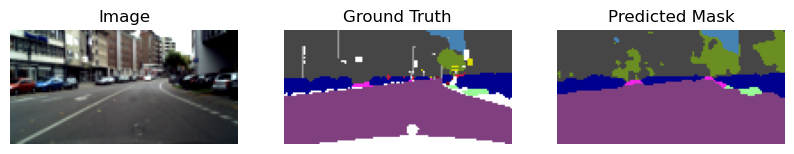

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


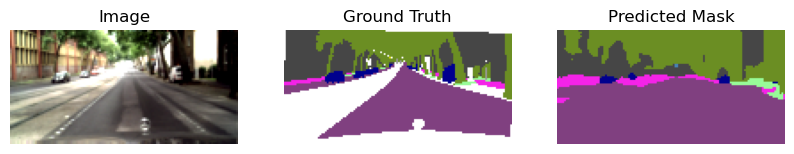

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


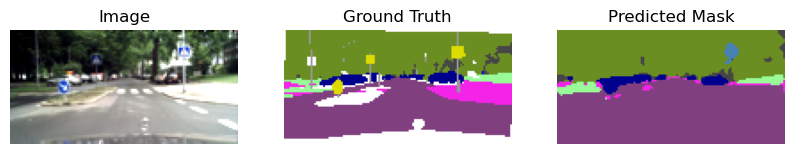

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


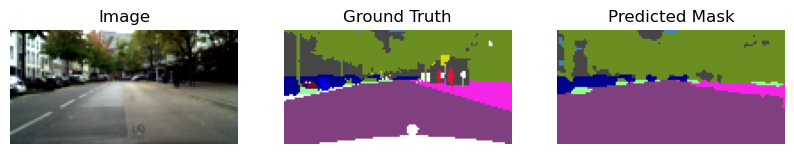

In [6]:
def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            masks = (masks*255).squeeze(1).long()
            masks1 = utils.map_id_to_train_id(masks)
            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            images = images.numpy()
            masks = masks1.numpy()

            predicted = predicted.numpy()

            for j in range(images.shape[0]):
                image = renormalize_image(images[j].transpose(1, 2, 0))
                mask = masks[j].squeeze()
                pred_mask = predicted[j]               
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
                plt.title(f'Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
                plt.title(f'Predicted Mask')
                plt.axis('off')

                plt.show()
def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]  
    renormalized_image = image * std + mean
    return renormalized_image

colors = {
        0: (128, 64,128),
        1: (244, 35,232),
        2: ( 70, 70, 70),  
        3: (102,102,156),   
        4: (190,153,153), 
        5: (153,153,153),
        6: (250,170, 30),
        7: (220,220,  0),
        8: (107,142, 35),
        9: (152,251,152),
        10: ( 70,130,180),
        11: (220, 20, 60),
        12: (255,  0,  0),
        13: (  0,  0,142),
        14: (  0,  0, 70),
        15: (  0, 60,100),
        16: (  0, 80,100),
        17: (  0,  0,230),
        18: (119, 11, 32),
        255:(255,255,255)
}

class_names = [
    'road', 'sidewalk','building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation',
    'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train','motorcycle','bicycle'
]
# Think about results
# torch.manual_seed(1)
visualize_segmentation(model, train_loader, num_examples=1)